In [7]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from pathlib import Path

# Provide the correct file path for our training file and our file to be predicted
data_file_path = Path('../Resources/PeterMac_HRD_Validation.csv')
predict_data_file_path = ('../Resources/PeterMac_HRD_Clinical/correct_PeterMac_HRD_clinical_data.csv')

data_df = pd.read_csv(data_file_path)
data_df.head()

data_df_predict = pd.read_csv(predict_data_file_path)


In [8]:
# Drop the non-beneficial ID columns, SampleID, SeqRunID, DDMSampleID
# Make these columns into One hot columns QAStatus, Gene, Variant
# Make a Y value column we actually want to test 
# testing if there is a difference between MyriadGIStatus and SophiaGIStatus
# Non-agreement 
# As we are testing the agreement of MyriadGiStatus(1/2) and SophiaGIStatus(1/2/3/4), we need to 
# collapse the test into a binary result.
#    MyriadGIStatus        SophiaGIStatus      Laboratory Classsification  Binary Result
#       1                       1                   TruePositive                1
#       1                       2                   False Negative              0
#       1                       3                   Inconclusive                0
#       1                       4                   Inconclusive                0
#       2                       1                   False Positive              0
#       2                       2                   True Negative               1
#       2                       3                   Inconclusive                0
#       2                       4                   Inconclusive                0
# Remove columns for X sample MyriadGIStatus, SophiaGIStatus, MyriadGIScore, SophiaGIIndex
# Non-agreement
# the Y value will be Non-agreement
# We have to decide how to handle columns with actual non-values
# being PurityPloidyRatio, Variant. Our lack of records and sparse grouping 
# makes these columns liklely to be dropped.
#  YOUR CODE GOES HERE
columns_to_drop = ["SampleID", "SeqRunID", "DDMSampleID","MonthsOld"]

# Drop the specified columns from the DataFrame
data_df = data_df.drop(columns=columns_to_drop, axis=1)
data_df.head()

data_df_predict = data_df_predict.drop(columns=columns_to_drop, axis=1)

In [9]:
# Finding attribute columns
application_categories = data_df.dtypes[data_df.dtypes == "object"].index.tolist()

# Check the number of unique values in each column of object type
columns = data_df[application_categories].nunique()

# Iterate through the columns and print the unique value counts for each column
# we iterate through every column in the dataframe, some of them of object type where we found the unique count
for column in data_df.columns:
    if column in columns.index:
        data_type = data_df[column].dtype
        print(f"{column.ljust(40)} (Data Type: {data_type}) - {columns[column]} unique value(s)")
    else:
        print(f"{column.ljust(20)} numeric- {data_df[column].nunique()} unique value(s)")



Run                  numeric- 13 unique value(s)
Source                                   (Data Type: object) - 4 unique value(s)
Purity                                   (Data Type: object) - 14 unique value(s)
MIDS                 numeric- 24 unique value(s)
TotalReads(M)        numeric- 95 unique value(s)
lpWGSReads(M)        numeric- 86 unique value(s)
TargetPanelReads(M)  numeric- 64 unique value(s)
%ReadslpWGS                              (Data Type: object) - 36 unique value(s)
%ReadsPanel                              (Data Type: object) - 36 unique value(s)
1000x                                    (Data Type: object) - 65 unique value(s)
500x                                     (Data Type: object) - 56 unique value(s)
200x                                     (Data Type: object) - 32 unique value(s)
100x                                     (Data Type: object) - 16 unique value(s)
50x                                      (Data Type: object) - 10 unique value(s)
25x               

In [10]:
# Convert columns we will not bin, from pobject type to numeric
column_names_to_convert = ['Purity']

# Step 1: Check the current data types of the columns
print(data_df[column_names_to_convert].dtypes)

# Step 2: Convert each column to numeric (if possible)
for col in column_names_to_convert:
    data_df[col] = pd.to_numeric(data_df[col], errors='coerce')
    data_df_predict[col] = pd.to_numeric(data_df_predict[col], errors='coerce') 
# Step 3: Check the new data types of the columns after the conversion
print(data_df[column_names_to_convert].dtypes)
# print(data_df["Source"].dtypes)

Purity    object
dtype: object
Purity    float64
dtype: object


In [11]:
print(data_df['%ReadslpWGS'].unique())
print(data_df['%ReadsPanel'].unique())


['81%' '76%' '64%' '63%' '58%' '54%' '90%' '89%' '84%' '85%' '98%' '72%'
 '68%' '69%' '74%' '66%' '73%' '70%' '80%' '86%' '15%' '91%' '62%' '79%'
 '88%' '92%' '71%' '77%' '59%' '60%' '55%' '65%' '67%' '57%' '61%' '75%']
['19%' '24%' '36%' '37%' '42%' '46%' '10%' '12%' '16%' '15%' '2%' '28%'
 '32%' '31%' '26%' '29%' '34%' '25%' '30%' '20%' '14%' '85%' '9%' '38%'
 '21%' '11%' '8%' '23%' '41%' '40%' '27%' '45%' '35%' '33%' '43%' '39%']


In [12]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
data_df['PurityPloidyRatio'] = data_df['PurityPloidyRatio'].replace('-', 0.0)
data_df['ResNoise'] = data_df['ResNoise'].replace('-', 0.0)
data_df['SignalNoiseRatio'] = data_df['SignalNoiseRatio'].replace('-', 0.0)

data_df['Gene'] = data_df['Gene'].replace('.', 'Unlisted')
data_df_predict['Gene'] = data_df_predict['Gene'].fillna('Unlisted')

# data_df['MonthsOld'] = data_df['MonthsOld'].fillna(0.0)
# data_df['MonthsOld'] = data_df['MonthsOld'].replace('.', 0.0)
data_df['Purity'] = data_df['Purity'].replace('.', 0.0)
data_df['%VariantFraction'] = data_df['%VariantFraction'].replace('.', 0.0)
data_df_predict['%VariantFraction'] = data_df_predict['%VariantFraction'].replace('',0.0)
# Convert the 'Purity' column to numeric, replacing '.' with 0.0
data_df['Purity'] = pd.to_numeric(data_df['Purity'], errors='coerce').fillna(0.0)

data_df['DupFrac'] = data_df['DupFrac'].replace('%', '', regex=True).astype(float)
data_df['%ReadslpWGS'] = data_df['%ReadslpWGS'].replace('%', '', regex=True).astype(float)
data_df['%ReadsPanel'] = data_df['%ReadsPanel'].replace('%', '', regex=True).astype(float)

data_df['Variant'] = data_df['Variant'].replace('.', 'Unlisted')

data_df_predict['Variant'] = data_df_predict['Variant'].fillna('Unlisted')
# Apply label encoding to 'Variant' column
label_encoder = LabelEncoder()
data_df['Variant'] = label_encoder.fit_transform(data_df['Variant'].astype(str))
data_df_predict['Variant'] = label_encoder.fit_transform(data_df_predict['Variant'].astype(str))

data_df_predict['Run'] = data_df_predict['Run'].str.replace('Run', '')
data_df_predict['MIDS'] = data_df_predict['MIDS'].str.replace('S', '')

data_df['1000x'] = data_df['1000x'].replace('%', '', regex=True).astype(float)

data_df['500x'] = data_df['1000x'].replace('%', '', regex=True).astype(float)
data_df['200x'] = data_df['1000x'].replace('%', '', regex=True).astype(float)
data_df['100x'] = data_df['1000x'].replace('%', '', regex=True).astype(float)
data_df['50x'] = data_df['1000x'].replace('%', '', regex=True).astype(float)
data_df['25x'] = data_df['1000x'].replace('%', '', regex=True).astype(float)

data_df_predict['MyriadGIScore'] = '0'
data_df_predict['MyriadGIStatus'] = '0'


In [13]:
def calculate_non_agreement(row):
    if row['MyriadGIStatus'] == 1 and row['SophiaGIStatus'] == 1:
        return 1
    elif row['MyriadGIStatus'] == 1 and row['SophiaGIStatus'] == 2:
        return 0
    elif row['MyriadGIStatus'] == 1 and row['SophiaGIStatus'] == 3:
        return 0
    elif row['MyriadGIStatus'] == 1 and row['SophiaGIStatus'] == 4:
        return 0
    elif row['MyriadGIStatus'] == 2 and row['SophiaGIStatus'] == 1:
        return 0
    elif row['MyriadGIStatus'] == 2 and row['SophiaGIStatus'] == 2:
        return 1
    elif row['MyriadGIStatus'] == 2 and row['SophiaGIStatus'] == 3:
        return 0
    elif row['MyriadGIStatus'] == 2 and row['SophiaGIStatus'] == 4:
        return 0
    else:
        return None

# Apply the function to create the 'Non-agreement' column
data_df['Non-agreement'] = data_df.apply(calculate_non_agreement, axis=1)
data_df_predict['Non-agreement'] = 'void'
#print(data_df['Non-agreement'].dtypes)
print(data_df)

     Run  Source  Purity  MIDS  TotalReads(M)  lpWGSReads(M)  \
0      1      AZ    20.0     2            7.3            5.9   
1      1      AZ    30.0     3            7.3            5.6   
2      1      AZ    20.0     4            9.6            6.1   
3      1      AZ    20.0     6            8.9            5.6   
4      1      AZ    60.0     7            8.6            5.0   
..   ...     ...     ...   ...            ...            ...   
134    6      AZ    10.0     3           25.5           18.8   
135   11  GREECE     0.0     4           18.6           13.0   
136    2      AZ    40.0    23           18.3           12.2   
137    5      AZ    50.0    23           14.0           10.5   
138   12  BRAZIL    60.0    23           21.6           15.5   

     TargetPanelReads(M)  %ReadslpWGS  %ReadsPanel  1000x  ...  \
0                    1.4         81.0         19.0    1.0  ...   
1                    1.7         76.0         24.0    2.0  ...   
2                    3.5         

In [29]:
print(data_df)

     Run  Source  Purity  MIDS  TotalReads(M)  lpWGSReads(M)  \
0      1      AZ    20.0     2            7.3            5.9   
1      1      AZ    30.0     3            7.3            5.6   
2      1      AZ    20.0     4            9.6            6.1   
3      1      AZ    20.0     6            8.9            5.6   
4      1      AZ    60.0     7            8.6            5.0   
..   ...     ...     ...   ...            ...            ...   
134    6      AZ    10.0     3           25.5           18.8   
135   11  GREECE     0.0     4           18.6           13.0   
136    2      AZ    40.0    23           18.3           12.2   
137    5      AZ    50.0    23           14.0           10.5   
138   12  BRAZIL    60.0    23           21.6           15.5   

     TargetPanelReads(M)  %ReadslpWGS  %ReadsPanel  1000x  ...  \
0                    1.4         81.0         19.0    1.0  ...   
1                    1.7         76.0         24.0    2.0  ...   
2                    3.5         

In [14]:
# Look at APPLICATION_TYPE value counts for binning  QAStatus

grouped_df = data_df.groupby("QAStatus").size().reset_index(name="COUNT")
sorted_df = grouped_df.sort_values(by="COUNT", ascending=False)
sorted_df = sorted_df.reset_index(drop=True)
print(sorted_df)
print('---')
grouped_df = data_df.groupby("Gene").size().reset_index(name="COUNT")
sorted_df = grouped_df.sort_values(by="COUNT", ascending=False)
sorted_df = sorted_df.reset_index(drop=True)
print(sorted_df)
print('---')
grouped_df = data_df.groupby("Variant").size().reset_index(name="COUNT")
sorted_df = grouped_df.sort_values(by="COUNT", ascending=False)
sorted_df = sorted_df.reset_index(drop=True)
print(sorted_df)
print('---')
grouped_df = data_df.groupby("PurityPloidyRatio").size().reset_index(name="COUNT")
sorted_df = grouped_df.sort_values(by="COUNT", ascending=False)
sorted_df = sorted_df.reset_index(drop=True)
print(sorted_df)

  QAStatus  COUNT
0     High     89
1   Medium     42
2      Low      8
---
       Gene  COUNT
0  Unlisted     99
1     BRCA1     21
2     BRCA2     18
3    RAD51D      1
---
    Variant  COUNT
0         0     99
1        14      2
2        21      2
3        36      1
4        27      1
5        22      1
6        23      1
7        24      1
8        25      1
9        37      1
10       26      1
11       28      1
12       35      1
13       20      1
14       30      1
15       31      1
16       32      1
17       33      1
18       34      1
19       29      1
20       19      1
21        1      1
22       18      1
23        2      1
24        3      1
25        4      1
26        5      1
27        6      1
28        7      1
29        8      1
30        9      1
31       10      1
32       11      1
33       12      1
34       13      1
35       15      1
36       16      1
37       17      1
38       38      1
---
   PurityPloidyRatio  COUNT
0                0.0     46
1    

In [15]:
# This is a dummy block of code in case we want to gather many column values into the same bucket
# application_types_to_replace = ["T9", "T13", "T12", "T2", "T14", "T25", "T29", "T15", "T17"]

# Replace the specified values in the "APPLICATION_TYPE" column with "Other"
# data_df['APPLICATION_TYPE'] = data_df['APPLICATION_TYPE'].replace(application_types_to_replace, "Other")

# Check the value counts after replacing
# print(data_df['APPLICATION_TYPE'].value_counts())

In [16]:
# Create one-hot columns for these 3 columns
onehot_cols = ["QAStatus", "Gene", "Variant"]  #"PurityPloidyRatio"]

# Use get_dummies() to one-hot encode only the categorical columns
one_hot_encoded = pd.get_dummies(data_df[onehot_cols])

# Concatenate the one-hot encoded columns with the original DataFrame
data_df = pd.concat([data_df, one_hot_encoded], axis=1)

one_hot_encoded = pd.get_dummies(data_df_predict[onehot_cols])
data_df_predict = pd.concat([data_df_predict, one_hot_encoded], axis=1 )
# After this, you can print the data types of columns in the 'data_df' DataFrame
column_types = data_df.dtypes
print(column_types)


Run                      int64
Source                  object
Purity                 float64
MIDS                     int64
TotalReads(M)          float64
lpWGSReads(M)          float64
TargetPanelReads(M)    float64
%ReadslpWGS            float64
%ReadsPanel            float64
1000x                  float64
500x                   float64
200x                   float64
100x                   float64
50x                    float64
25x                    float64
DupFrac                float64
LowCovRegions            int64
PurityPloidyRatio       object
ResNoise                object
SignalNoiseRatio        object
QAStatus                object
Gene                    object
Variant                  int64
%VariantFraction        object
MyriadGIScore            int64
MyriadGIStatus           int64
SOPHiAGIIndex           object
SophiaGIStatus           int64
Non-agreement            int64
Variant                  int64
QAStatus_High            uint8
QAStatus_Low             uint8
QAStatus

## Compile, Train and Evaluate the Model

In [17]:
def final_callback(message):
    print(f"Final callback: {message}")

In [18]:
def loss_accuracy_callback(epoch, loss, accuracy):
    print(f"Epoch {epoch}: Loss={loss:.4f}, Accuracy={accuracy:.4f}")

In [19]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger
from datetime import datetime

def main_process(callback, X_train_scaled, y_train, nn, report_interval=5):
    # Train the model and store the training history
    fit_model = nn.fit(X_train_scaled, y_train, epochs=100, verbose=0, callbacks=[callback])  # Pass the callback here
    training_history = fit_model.history
    
    print("Training has started.")
    epochs = 100
    
    # Report loss and accuracy at the specified intervals
    for epoch in range(1, epochs + 1):
        if epoch % report_interval == 0 or epoch == epochs:
            loss = training_history['loss'][epoch - 1]
            accuracy = training_history['accuracy'][epoch - 1]
            print(f"Epoch {epoch}: Loss={loss:.4f}, Accuracy={accuracy:.4f}")#soos2
            callback.on_epoch_end(epoch, {'loss': loss, 'accuracy': accuracy})  # Manually call the on_epoch_end method

    result = "Task completed."
    # final_callback(result)  # Comment out or remove this line as it is not defined in the code
    print("Main process finished.")

# soos
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
script_name = "Starter_Codev1"
csv_loss_accuracy_file = "startercodetest.csv"
#csv_loss_accuracy_file_name = f"{script_name}_test_result_{current_datetime}.csv"

# Create the CSVLogger callback and pass the file name
csv_logger = CSVLogger(csv_loss_accuracy_file)







## Optimisation
### In our original model, we created data frame application_df, which still exists.
- 1. I will create a pca method on this data frame which has had bucketing


In [20]:
# 1  pca method on application_df which has had bucketing performed for the original model.
data_df_x = data_df.copy() 
columns_to_drop = ["Gene", "Non-agreement", "MyriadGIStatus", "SophiaGIStatus", "MyriadGIScore", "SOPHiAGIIndex", "QAStatus"]
data_df_x = data_df_x.drop(columns=columns_to_drop, axis=1)

data_df_predict_x = data_df_predict.copy()
data_df_predict_x = data_df_predict_x.drop(columns=columns_to_drop, axis=1)

#data_df_x = data_df_x.drop(columns=["Gene","Source","Non_agreement", "MyriadGIStatus", "SophiaGIStatus", "MyriadGIScore", "SOPHiAGIIndex","QAStatus"], axis=1)
data_df_x.columns

Index(['Run', 'Source', 'Purity', 'MIDS', 'TotalReads(M)', 'lpWGSReads(M)',
       'TargetPanelReads(M)', '%ReadslpWGS', '%ReadsPanel', '1000x', '500x',
       '200x', '100x', '50x', '25x', 'DupFrac', 'LowCovRegions',
       'PurityPloidyRatio', 'ResNoise', 'SignalNoiseRatio', 'Variant',
       '%VariantFraction', 'Variant', 'QAStatus_High', 'QAStatus_Low',
       'QAStatus_Medium', 'Gene_BRCA1', 'Gene_BRCA2', 'Gene_RAD51D',
       'Gene_Unlisted'],
      dtype='object')

In [21]:
data_df_predict_x.columns

Index(['Run', 'Source', 'Purity', 'MIDS', 'TotalReads(M)', 'lpWGSReads(M)',
       'TargetPanelReads(M)', '%ReadslpWGS', '%ReadsPanel', '1000x', '500x',
       '200x', '100x', '50x', '25x', 'DupFrac', 'LowCovRegions',
       'PurityPloidyRatio', 'ResNoise', 'SignalNoiseRatio', 'Variant',
       '%VariantFraction', 'Variant', 'QAStatus_High', 'QAStatus_Medium',
       'Gene_BRCA1', 'Gene_BRCA2', 'Gene_Unlisted'],
      dtype='object')

In [22]:
#data_df_x
# Step 1: Check which columns have missing values (NaN)
columns_with_missing_values = data_df_x.isna().any()

# Step 2: Output the columns where the count of missing values is larger than 0
columns_with_missing_values = columns_with_missing_values[columns_with_missing_values]

# Output the columns with missing values
print(columns_with_missing_values)
#print(data_df_x['%ReadslpWGS'].unique())
#print(data_df_x['%ReadsPanel'].unique())


Series([], dtype: bool)


In [23]:
# Check unique values in the "%VariantFraction" column
print(data_df['%VariantFraction'].unique())


[0.0 '42.6' '78.1' '78.5' '77.2' '22.1' '37.8' '56.4' '24.4' '87' '54.6'
 '51.1' '85.8' '71.8' '66.1' '9' '87.4' '84.1' '80.4' '73' '67.6' '17.3'
 '9.1' '35.8' '82.8' '80.5' 'Deleted' '18.7' '65.3' '51.8' '68.8' '62.6'
 '71.2' '89.8' '47' '59.6' '5.4' '26.7' '64.7']


In [24]:
# Replace "Deleted" with 0 in the '%ReadslpWGS' column
data_df_x['%VariantFraction'] = data_df_x['%VariantFraction'].replace('Deleted', 0)

# Convert the column to numeric (float) format
data_df_x['%VariantFraction'] = pd.to_numeric(data_df_x['%VariantFraction'])


In [25]:
#data_df_x.columns
import pandas as pd

# Assuming 'data_df_x' is the DataFrame containing the data
non_numeric_columns = data_df_x.select_dtypes(exclude=['number']).columns

print("Non-numeric columns:")
print(non_numeric_columns)


Non-numeric columns:
Index(['Source', 'PurityPloidyRatio', 'ResNoise', 'SignalNoiseRatio'], dtype='object')


In [26]:
non_numeric_columns = data_df_x.select_dtypes(exclude=[np.number]).columns
print(non_numeric_columns)



Index(['Source', 'PurityPloidyRatio', 'ResNoise', 'SignalNoiseRatio'], dtype='object')


In [27]:
# Check data types of the columns in data_df_x
print(data_df_x.dtypes)

# Check for missing values in data_df_x
print(data_df_x.isnull().sum())

# Convert the '%VariantFraction' column to numeric values, invalid values will be converted to NaN
data_df_x['%VariantFraction'] = pd.to_numeric(data_df_x['%VariantFraction'], errors='coerce')

# Create a mask to identify rows with NaN values in the '%VariantFraction' column
invalid_rows_mask = data_df_x['%VariantFraction'].isna()

# Use the mask to filter the DataFrame and get the rows with invalid values
invalid_rows = data_df_x[invalid_rows_mask]




# Check if any non-numeric values still exist in data_df_x
non_numeric_values = data_df_x.apply(pd.to_numeric, errors='coerce').isnull().sum()
print(non_numeric_values)


Run                      int64
Source                  object
Purity                 float64
MIDS                     int64
TotalReads(M)          float64
lpWGSReads(M)          float64
TargetPanelReads(M)    float64
%ReadslpWGS            float64
%ReadsPanel            float64
1000x                  float64
500x                   float64
200x                   float64
100x                   float64
50x                    float64
25x                    float64
DupFrac                float64
LowCovRegions            int64
PurityPloidyRatio       object
ResNoise                object
SignalNoiseRatio        object
Variant                  int64
%VariantFraction       float64
Variant                  int64
QAStatus_High            uint8
QAStatus_Low             uint8
QAStatus_Medium          uint8
Gene_BRCA1               uint8
Gene_BRCA2               uint8
Gene_RAD51D              uint8
Gene_Unlisted            uint8
dtype: object
Run                    0
Source                 0
Purity

In [28]:
# Check for non-numeric columns
non_numeric_cols = data_df_x.select_dtypes(exclude=[np.number]).columns
print("Non-numeric columns:", non_numeric_cols)

# Check for missing values
missing_values = data_df_x.isnull().sum()
print("Missing values:\n", missing_values)


Non-numeric columns: Index(['Source', 'PurityPloidyRatio', 'ResNoise', 'SignalNoiseRatio'], dtype='object')
Missing values:
 Run                    0
Source                 0
Purity                 0
MIDS                   0
TotalReads(M)          0
lpWGSReads(M)          0
TargetPanelReads(M)    0
%ReadslpWGS            0
%ReadsPanel            0
1000x                  0
500x                   0
200x                   0
100x                   0
50x                    0
25x                    0
DupFrac                0
LowCovRegions          0
PurityPloidyRatio      0
ResNoise               0
SignalNoiseRatio       0
Variant                0
%VariantFraction       0
Variant                0
QAStatus_High          0
QAStatus_Low           0
QAStatus_Medium        0
Gene_BRCA1             0
Gene_BRCA2             0
Gene_RAD51D            0
Gene_Unlisted          0
dtype: int64


In [29]:
columns_to_drop = ['Variant', 'Source']
data_df_x = data_df_x.drop(columns=columns_to_drop)

data_df_predict_x = data_df_predict_x.drop(columns=columns_to_drop)

data_df_x.columns


Index(['Run', 'Purity', 'MIDS', 'TotalReads(M)', 'lpWGSReads(M)',
       'TargetPanelReads(M)', '%ReadslpWGS', '%ReadsPanel', '1000x', '500x',
       '200x', '100x', '50x', '25x', 'DupFrac', 'LowCovRegions',
       'PurityPloidyRatio', 'ResNoise', 'SignalNoiseRatio', '%VariantFraction',
       'QAStatus_High', 'QAStatus_Low', 'QAStatus_Medium', 'Gene_BRCA1',
       'Gene_BRCA2', 'Gene_RAD51D', 'Gene_Unlisted'],
      dtype='object')

In [30]:
data_df_predict_x.columns
data_df_predict_x['QAStatus_Low'] = 0
data_df_predict_x['Gene_RAD51D'] = 0

In [31]:
invalid_rows = data_df_x['%VariantFraction'].apply(lambda x: not str(x).replace('.', '').isnumeric())

# Display the rows containing the invalid values
print(data_df_x[invalid_rows])


Empty DataFrame
Columns: [Run, Purity, MIDS, TotalReads(M), lpWGSReads(M), TargetPanelReads(M), %ReadslpWGS, %ReadsPanel, 1000x, 500x, 200x, 100x, 50x, 25x, DupFrac, LowCovRegions, PurityPloidyRatio, ResNoise, SignalNoiseRatio, %VariantFraction, QAStatus_High, QAStatus_Low, QAStatus_Medium, Gene_BRCA1, Gene_BRCA2, Gene_RAD51D, Gene_Unlisted]
Index: []

[0 rows x 27 columns]


In [32]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assume data_df_x contains the features, and data_df contains the target "Non_agreement" column

# Split our preprocessed data into our features and target arrays
y2 = data_df["Non-agreement"].values
X2 = data_df_x.values
X3 = data_df_predict_x.values
# Split the preprocessed data into a training and testing dataset
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=78)

# Create a new scaler instance and fit it on the training data
scaler = StandardScaler()
X2_train_scaled = scaler.fit_transform(X2_train)

# Transform both the training and testing data using the same scaler
X2_test_scaled = scaler.transform(X2_test)
X3_scaled = scaler.transform(X3)
# Now perform PCA on the scaled training data
pca = PCA(n_components=3)
X2_train_pca = pca.fit_transform(X2_train_scaled)

# Apply the same PCA transformation to the scaled testing data
X2_test_pca = pca.transform(X2_test_scaled)

# Check the number of records in the original dataset
print(data_df_x.shape)

# Check the number of records after splitting into training and testing sets
print(X2_train.shape, X2_test.shape)

# Check the number of records after PCA transformation
print(X2_train_pca.shape, X2_test_pca.shape)

# Create a new DataFrame with the PCA data for both training and testing sets
df_train_pca = pd.DataFrame(X2_train_pca, columns=["PC1", "PC2", "PC3"])
df_test_pca = pd.DataFrame(X2_test_pca, columns=["PC1", "PC2", "PC3"])



from sklearn.impute import SimpleImputer

# Create an imputer instance with the strategy as 'constant' and fill_value as 0
imputer = SimpleImputer(strategy='constant', fill_value=0)

# Impute missing values in X3_scaled with 0
X3_imputed = imputer.fit_transform(X3_scaled)

# Perform PCA on the imputed data
X3_pca = pca.transform(X3_imputed)



(139, 27)
(111, 27) (28, 27)
(111, 3) (28, 3)


In [49]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=30,
        step=2), activation=activation, input_dim=3))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=30,
            step=2),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [50]:
# Import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=100,
    hyperband_iterations=2)

In [51]:
# Note: Use RSoos Scaled train data and test here
# Run the kerastuner search for best hyperparameters
tuner.search(X2_train_pca,y2_train,epochs=100,validation_data=(X2_test_pca,y2_test))

Trial 508 Complete [00h 00m 07s]
val_accuracy: 0.7142857313156128

Best val_accuracy So Far: 0.8571428656578064
Total elapsed time: 00h 20m 20s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters(3)
best_hyper.values

In [55]:
# Evaluate best model against full test data
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X2_test_pca,y2_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

1/1 - 0s - loss: 0.6099 - accuracy: 0.8571 - 225ms/epoch - 225ms/step
Loss: 0.6098801493644714, Accuracy: 0.8571428656578064


In [57]:
# Save optimized model
best_model.save('./Kerastuner/untitled_project/PCA3rdAttempt_optimised_model.h5')


/Users/Shared/anaconda3/envs/bootcamp/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [59]:
# Perform predictions with best model on clinical data
from tensorflow.keras.models import load_model

optimized_model = load_model('./Kerastuner/untitled_project/PCA3rdAttempt_optimised_model.h5')
predictions = optimized_model.predict(X3_pca)

3/3 [==============================] - 0s 2ms/step


In [60]:
print(predictions)

[[0.5615081 ]
 [0.4854239 ]
 [0.58651936]
 [0.566744  ]
 [0.5992895 ]
 [0.5167243 ]
 [0.5854251 ]
 [0.541069  ]
 [0.5171153 ]
 [0.52674395]
 [0.5543784 ]
 [0.53281784]
 [0.5615725 ]
 [0.5572183 ]
 [0.53708255]
 [0.56197864]
 [0.5010312 ]
 [0.535943  ]
 [0.5332915 ]
 [0.57277566]
 [0.4383167 ]
 [0.544989  ]
 [0.5499791 ]
 [0.46143505]
 [0.5345393 ]
 [0.52490515]
 [0.50299704]
 [0.5458166 ]
 [0.4781204 ]
 [0.5718261 ]
 [0.5489444 ]
 [0.557952  ]
 [0.48067078]
 [0.61916554]
 [0.4833243 ]
 [0.5262348 ]
 [0.6229367 ]
 [0.5567674 ]
 [0.58706   ]
 [0.4813462 ]
 [0.56450397]
 [0.5056111 ]
 [0.5526079 ]
 [0.5664058 ]
 [0.54611105]
 [0.53274   ]
 [0.487293  ]
 [0.5435706 ]
 [0.599164  ]
 [0.4927046 ]
 [0.5531179 ]
 [0.56874657]
 [0.5067635 ]
 [0.56504965]
 [0.5541978 ]
 [0.59911114]
 [0.4926737 ]
 [0.5732316 ]
 [0.59688765]
 [0.5013998 ]
 [0.5526465 ]
 [0.5435646 ]
 [0.54255474]
 [0.45894307]
 [0.51607066]
 [0.55038595]
 [0.49893686]
 [0.44916606]
 [0.53094167]
 [0.52430284]
 [0.5657432 ]
 [0.51

In [63]:
import csv
with open('./Kerastuner/untitled_project/predictions_output.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(predictions)    # Write the data rows

## Simulate training of optimised model to generate data for accuracy /loss curves

In [33]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

In [34]:
# Reload optimised model
optimized_model = load_model('./PCA_3rdAttemptProject_AF_trials/PCA3rdAttempt_optimised_model.h5')

In [35]:
# Compile the model
optimized_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
# Simulate training process using the test data
history = optimized_model.fit(X2_train_pca, y2_train,epochs=100, validation_data=(X2_test_pca,y2_test), verbose=1)

Epoch 1/100


/Users/Shared/anaconda3/envs/bootcamp/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


4/4 [==============================] - 2s 85ms/step - loss: 0.0000e+00 - accuracy: 0.5856 - val_loss: 0.0000e+00 - val_accuracy: 0.8571
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - accuracy: 0.5856 - val_loss: 0.0000e+00 - val_accuracy: 0.8571
Epoch 3/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - accuracy: 0.5946 - val_loss: 0.0000e+00 - val_accuracy: 0.8571
Epoch 4/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - accuracy: 0.5946 - val_loss: 0.0000e+00 - val_accuracy: 0.8571
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - accuracy: 0.5676 - val_loss: 0.0000e+00 - val_accuracy: 0.8929
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - accuracy: 0.5586 - val_loss: 0.0000e+00 - val_accuracy: 0.8929
Epoch 7/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - accuracy: 0.5676 - val_loss: 0.0000e+00

In [37]:
# Extract Training History
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, 101)

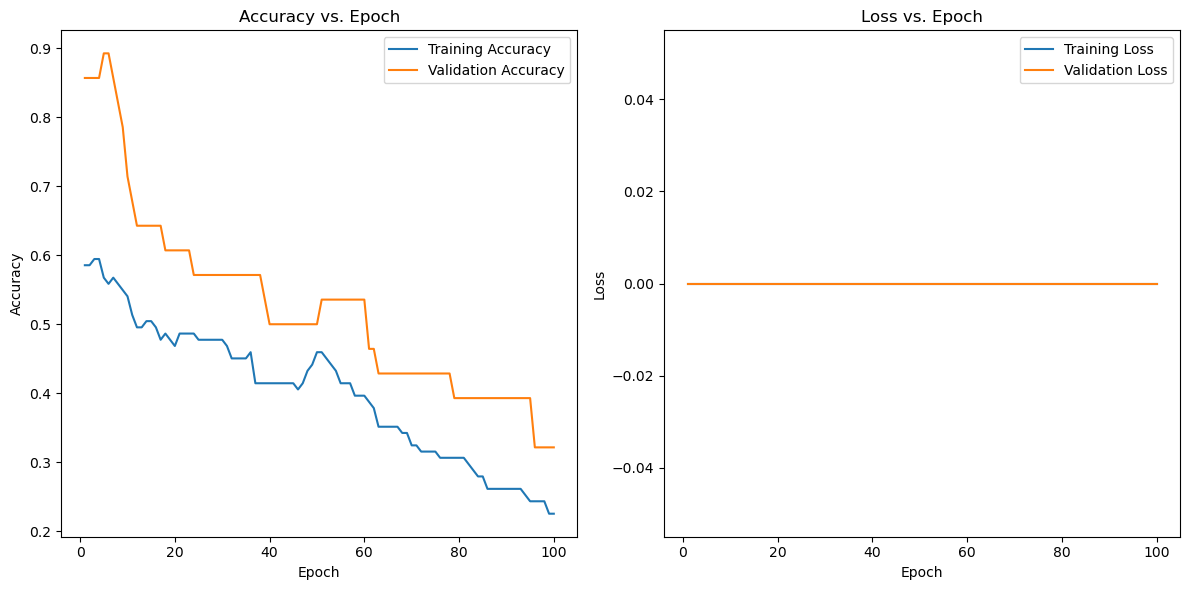

In [38]:
# Plot Accuracy and Loss Curves
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()